# Part B: Text classification

The dataset used in this project contains the first paragraphs collected from Wikipage entries and the corresponding labels about their category. You will implement CNN and RNN layers at the word and character levels for the classification of texts in the paragraphs. The output layer of the networks is a softmax layer.

In [ ]:
# import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
print(tf.__version__)

2.3.0


In [ ]:
# make sure Google Colaboratory is using GPU instance
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# set seed for replication
# random shuffling while fitting
seed = 0
tf.random.set_seed(seed)

The training and test datasets will be read from **'train_medium.csv'** and **'test_medium.csv'** files. The training dataset contains 5600 entries and test dataset contains 700 entries. The label of an entry is one of the 15 categories such as people, company, schools, etc.

In [ ]:
num_categories = 15

In [ ]:
# files uploaded to Google Colaboratory
train_data_path = '/content/CZ4042_assignment2/train_medium.csv'
test_data_path = '/content/CZ4042_assignment2/test_medium.csv'

In [ ]:
# take a look at the data
with open(train_data_path) as data_file:
    for index, line in enumerate(data_file):
        # first 5 lines is enough
        if index >= 5:
            break

        print(line)

7, Park Dinor is a historic diner located at Lawrence Park Township Erie County Pennsylvania. It was built in 1948 by the Paterson Vehicle Co. of Paterson New Jersey. It is a one-story pre-fabricated stainless steel and porcelain building. The diner measures 40 feet long by 14 feet wide and has an attached concrete block kitchen measuring 13 feet by 11 feet six inches. Also on the property is a contributing pre-fabricated 384 square foot cottage also erected in 1948.,,,,,,,

9, Betan is a village development committee in Surkhet District in the Bheri Zone of mid-western Nepal. At the time of the 1991 Nepal census it had a population of 2644 people living in 407 individual households.,,,,,,,

4, Christopher Benjamin Rungkat (born 14 January 1990) is an Indonesian tennis player. He is the grandson of Famous Benny Rungkat former chairman of the Indonesian Air Carriers Association. Christopher's father Michael Alexander Fritz Rungkat is of Dutch and Indonesian descent and his mother Elfia 

In [ ]:
def get_data_from_text(data_file_path: str):
    '''
    Get the raw data from a text file

    :params:
    - data_file_path (str): path to text file that contains data

    :return:
    - a list of integer labels, a list of string features of the same length
    '''
    features, labels = [], []
    with open(data_file_path) as data_file:
        
        for line in data_file:
            line = line.replace(',,,,,,,\n', '')
            category, entry = tuple(line.split(', ', maxsplit=1))
            
            features.append(entry)
            labels.append(int(category))

    return features, labels

In [ ]:
raw_train_features, raw_train_labels = get_data_from_text(train_data_path)

print(f'number of train features: {len(raw_train_features)}')

# actual number of categories does not affect results
print(f'train labels: {sorted(set(raw_train_labels))}')

raw_test_features, raw_test_labels = get_data_from_text(test_data_path)

print(f'number of test features: {len(raw_test_features)}')

# actual number of categories does not affect results
print(f'test labels: {sorted(set(raw_test_labels))}')

number of train features: 5600
train labels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
number of test features: 700
test labels: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]


The input data is in text, which should be converted to character/word IDs to feed to the networks (Please refer to our given two smaple codes (CNN and RNN) which process text data in terms of character and word respectively). Restrict the maximum length of the characters/word inputs to **100** and the maximum number of training epoch to **250**. Use the **Adam or SGD optimizers** for training with a **batch size = 128** and **learning rate = 0.01**. Assume there are **256** different characters.

In [ ]:
# specify params as global variables
max_input_length = 100
num_epochs = 250
batch_size = 128
learning_rate = 0.01
sgd = optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
num_characters = 256

# additional params
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['sparse_categorical_accuracy']

# 1. 

Design a Character CNN Classifier that receives character ids and classifies the input. The CNN has two convolution and pooling layers:

- A convolution layer $C_1$ of 10 filters of window size 20x256, VALID padding, and ReLU neurons. A max pooling layer $S_1$ with a pooling window of size 4x4, with stride = 2, and padding = 'SAME'.
- A convolution layer $C_2$ of 10 filters of window size 20x1, VALID padding, and ReLU neurons. A max pooling layer $S_2$ with a pooling window of size 4x4, with stride = 2 and padding = 'SAME'.

Plot the entropy cost on the training data and the accuracy on the testing data against
training epochs.

In [ ]:
# reference: sample code's vocabulary()
def get_char_id_map(strings: list) -> dict:
    '''
    Gives a mapping of each character to its corresponding id.

    :params:
    - strings (list): a list of strings

    :return:
    - a map of characters to their corresponding ids (dict)
    '''
    characters = sorted(set(''.join(strings).lower()))
    char_id_map = {char: id for id, char in enumerate(characters)}
    
    return char_id_map

In [ ]:
# reference: sample code's preprocess()
def convert_char_to_id(strings: list, char_id_map: dict) -> np.ndarray:
    '''
    encode as 2d array:
    number of rows -> number of entries
    number of columns -> entry length (normalised to max_input_length)
    '''
    char_encodings = []

    for string in strings:
        string = string.lower()
        if len(string) > max_input_length:  # too long -> truncate
            string = string[:max_input_length]
        
        elif len(string) < max_input_length:  # too short -> pad white space
            string += ' ' * (max_input_length - len(string))

        char_encodings.append([char_id_map[char] for char in string])

    return np.array(char_encodings)

In [ ]:
# reference: sample code
def convert_one_hot_cnn(features):
    one_hot_features = tf.one_hot(features, num_characters)
    one_hot_features = tf.expand_dims(one_hot_features, axis=-1)

    return one_hot_features

In [ ]:
def preprocess_char_data_cnn(
    train_data_path,
    test_data_path,
) -> tuple:
    '''
    Preprocess data for CNN character classification
    '''
    raw_train_features, raw_train_labels = get_data_from_text(train_data_path)
    raw_test_features, raw_test_labels = get_data_from_text(test_data_path)

    char_id_map = get_char_id_map(raw_train_features + raw_test_features)

    # give each character an id
    train_features = convert_char_to_id(raw_train_features, char_id_map)
    test_features = convert_char_to_id(raw_test_features, char_id_map)

    # convert id to one-hot encoding
    train_features = convert_one_hot_cnn(train_features)
    test_features = convert_one_hot_cnn(test_features)

    # convert labels to right format
    train_labels = np.array(raw_train_labels)
    test_labels = np.array(raw_test_labels)

    vocab_size = len(char_id_map.keys())

    return train_features, train_labels, test_features, test_labels, vocab_size

In [ ]:
# preprocess data
(
    train_features, train_labels,
    test_features, test_labels,
    vocab_size,
 ) = preprocess_char_data_cnn(train_data_path, test_data_path)

# print out data info
print(f'vocabulary size: {vocab_size}')

print(f'train features shape: {train_features.shape}')
print(f'train labels shape: {train_labels.shape}')

print(f'test features shape: {test_features.shape}')
print(f'test labels shape: {test_labels.shape}')

vocabulary size: 1173
train features shape: (5600, 100, 256, 1)
train labels shape: (5600,)
test features shape: (700, 100, 256, 1)
test labels shape: (700,)


In [ ]:
def get_character_cnn(
    input_shape: tuple,
    num_categories: int,
    use_dropout: bool = False,
) -> tf.keras.models.Sequential:
    '''
    Generates a word CNN classifier.

    :params:
    - input_shape (tuple): shape of the one-hot encoding of input data
    - num_categories (int): number of classes to classify
    - use_dropout (bool): whether to use dropout rate of 0.5 (default: False)

    :return:
    - an initial model (tf.keras.Sequential)
    '''
    input_layer = tf.keras.layers.Input(
        shape=input_shape,
    )

    c1 = tf.keras.layers.Conv2D(
        filters=10,
        kernel_size=(20, 256),
        padding='valid',
        activation='relu',
    )

    s1 = tf.keras.layers.MaxPool2D(
        pool_size=(4, 4),
        strides=2,
        padding='same',
    )

    if use_dropout:
        dropout1 = tf.keras.layers.Dropout(rate=0.5)
        model.add(dropout1)

    c2 = tf.keras.layers.Conv2D(
        filters=10,
        kernel_size=(20, 1),
        padding='valid',
        activation='relu',
    )

    s2 = tf.keras.layers.MaxPool2D(
        pool_size=(4, 4),
        strides=2,
        padding='same',
    )

    if use_dropout:
        dropout2 = tf.keras.layers.Dropout(rate=0.5)
        model.add(dropout2)

    flatten = tf.keras.layers.Flatten()

    fully_connected = tf.keras.layers.Dense(
        units=num_categories,
        # no need for softmax due to sparse categorical crossentropy loss,
        # according to sample code
    )

    return tf.keras.models.Sequential([
        input_layer,
        c1,
        s1,
        c2,
        s2,
        flatten,
        fully_connected,
    ])

In [ ]:
# train using SGD
model = get_character_cnn(
    input_shape=(max_input_length, num_characters, 1),
    num_categories=num_categories,
)
model.compile(
    optimizer=sgd,
    loss=loss,
    metrics=metrics,
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 81, 1, 10)         51210     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 41, 1, 10)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 1, 10)         2010      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 11, 1, 10)         0         
_________________________________________________________________
flatten (Flatten)            (None, 110)               0         
_________________________________________________________________
dense (Dense)                (None, 15)                1665      
Total params: 54,885
Trainable params: 54,885
Non-trainable params: 0
____________________________________________________

In [ ]:
%%time
history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(test_features, test_labels),
    verbose=0,  # too much output may crash browser
)

CPU times: user 2min 15s, sys: 10.3 s, total: 2min 26s
Wall time: 2min 24s


In [ ]:
%%time
results = model.evaluate(
    x=test_features,
    y=test_labels,
    batch_size=batch_size,
)

6/6 [==============================] - 0s 8ms/step - loss: 1.4203 - sparse_categorical_accuracy: 0.6600
CPU times: user 102 ms, sys: 5.16 ms, total: 108 ms
Wall time: 107 ms


In [ ]:
# define function to plot loss and accuracy curves for usage later
def plot_loss_accuracy_curves(num_epochs: int, history: dict):
    '''
    Plots loss curve and accuracy curve side-by-side.
    
    :params:
    - total_num_epochs (int): total number of epochs for model to get minimal test error
    - history (dict): history of loss and accuracy values at each epoch
        - keys: 'loss', 'val_loss', 'accuracy', 'val_accuracy'
    '''
    _, (loss_axis, accuracy_axis) = plt.subplots(nrows=1, ncols=2, figsize=(24, 6))

    loss_axis.set_title('loss')
    loss_axis.plot(range(num_epochs), history['loss'], label='train')
    loss_axis.plot(range(num_epochs), history['val_loss'], label='test')
    loss_axis.legend()

    accuracy_axis.set_title('accuracy')
    accuracy_axis.plot(range(num_epochs), history['sparse_categorical_accuracy'], label='train')
    accuracy_axis.plot(range(num_epochs), history['val_sparse_categorical_accuracy'], label='test')
    accuracy_axis.legend()

highest validation accuracy achieved: 0.6714285612106323


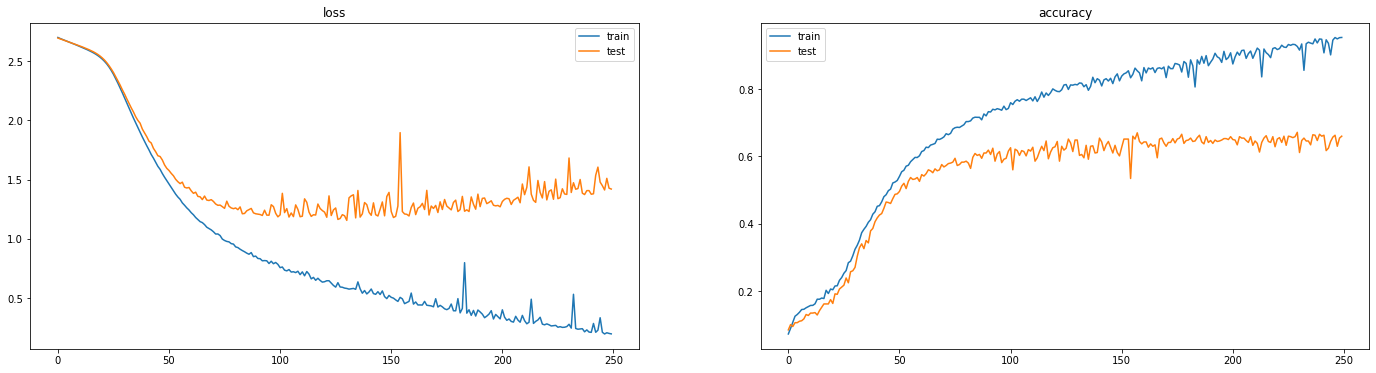

In [ ]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_sparse_categorical_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

In [ ]:
# train using Adam
model = get_character_cnn(
    input_shape=(max_input_length, num_characters, 1),
    num_categories=num_categories,
)
model.compile(
    optimizer=adam,
    loss=loss,
    metrics=metrics,
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 81, 1, 10)         51210     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 41, 1, 10)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 1, 10)         2010      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 11, 1, 10)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 110)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 15)                1665      
Total params: 54,885
Trainable params: 54,885
Non-trainable params: 0
__________________________________________________

In [ ]:
%%time
history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(test_features, test_labels),
    verbose=0,  # too much output may crash browser
)

CPU times: user 2min 12s, sys: 9.07 s, total: 2min 21s
Wall time: 2min 22s


In [ ]:
%%time
results = model.evaluate(
    x=test_features,
    y=test_labels,
    batch_size=batch_size,
)

6/6 [==============================] - 0s 8ms/step - loss: 7.0411 - sparse_categorical_accuracy: 0.5929
CPU times: user 101 ms, sys: 8.36 ms, total: 109 ms
Wall time: 107 ms


highest validation accuracy achieved: 0.6000000238418579


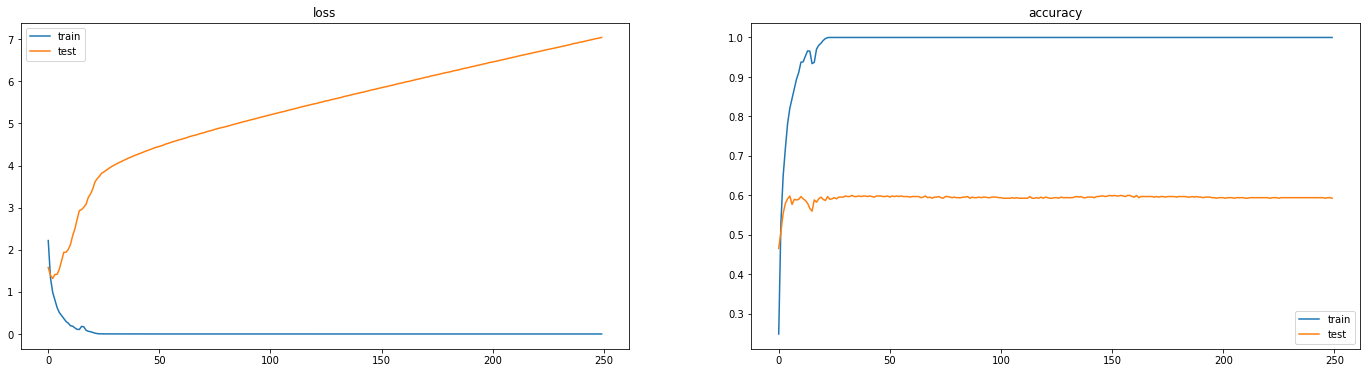

In [ ]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_sparse_categorical_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

# 2. 

Design a Word CNN Classifier that receives word ids and classifies the input. Pass the inputs through an embedding layer of size 20 before feeding to the CNN. The CNN has two convolution and pooling layers with the following characteristics:

- A convolution layer $C_1$ of 10 filters of window size 20x20, VALID padding, and ReLU neurons. A max pooling layer $S_1$ with a pooling window of size 4x4, with stride = 2 and padding = 'SAME'.
- A convolution layer $C_2$ of 10 filters of window size 20x1, , VALID padding, and ReLU neurons. A max pooling layer $S_2$ with a pooling window of size 4x4, with stride = 2 and padding = 'SAME'.

Plot the entropy cost on training data and the accuracy on testing data against training epochs.

In [ ]:
# try out Tensorflow's tokenizer
words = tf.keras.preprocessing.text.text_to_word_sequence(raw_train_features[0])
print(words)

['park', 'dinor', 'is', 'a', 'historic', 'diner', 'located', 'at', 'lawrence', 'park', 'township', 'erie', 'county', 'pennsylvania', 'it', 'was', 'built', 'in', '1948', 'by', 'the', 'paterson', 'vehicle', 'co', 'of', 'paterson', 'new', 'jersey', 'it', 'is', 'a', 'one', 'story', 'pre', 'fabricated', 'stainless', 'steel', 'and', 'porcelain', 'building', 'the', 'diner', 'measures', '40', 'feet', 'long', 'by', '14', 'feet', 'wide', 'and', 'has', 'an', 'attached', 'concrete', 'block', 'kitchen', 'measuring', '13', 'feet', 'by', '11', 'feet', 'six', 'inches', 'also', 'on', 'the', 'property', 'is', 'a', 'contributing', 'pre', 'fabricated', '384', 'square', 'foot', 'cottage', 'also', 'erected', 'in', '1948']


In [ ]:
# reference: sample code's build_word_dict()
def get_word_id_map(strings: list) -> dict:
    '''
    Gives a mapping of each word to its corresponding id.

    :params:
    - strings (list): a list of strings

    :return:
    - a map of words to their corresponding ids (dict)
    '''
    # <pad> -> to pad entry length if it is too short
    # <unk> -> id for any words that are unknown
    word_set = set(['<pad>', '<unk>', '<eos>'])

    for string in strings:
        words = tf.keras.preprocessing.text.text_to_word_sequence(string)
        word_set = word_set.union(words)
    
    word_id_map = {word: id for id, word in enumerate(word_set)}

    return word_id_map

In [ ]:
# reference: sample code's preprocess()
def convert_word_to_id(strings: list, word_id_map: dict) -> np.ndarray:
    '''
    encode as 2d array:
    number of rows -> number of entries
    number of columns -> entry length (normalised to max_input_length)
    '''
    word_encodings = []

    for string in strings:
        words = tf.keras.preprocessing.text.text_to_word_sequence(string)
        words += ['<eos>']

        if len(words) > max_input_length:  # too long -> truncate
            words = words[:max_input_length]
        
        elif len(words) < max_input_length:  # too short -> pad white space
            words += ['<pad>'] * (max_input_length - len(words))

        word_encodings.append([
            word_id_map.get(word, word_id_map['<unk>'])
            for word in words
        ])

    return np.array(word_encodings)

In [ ]:
def preprocess_word_data_cnn(train_data_path, test_data_path) -> tuple:
    '''
    Preprocess data for word classification using CNN
    '''
    raw_train_features, raw_train_labels = get_data_from_text(train_data_path)
    raw_test_features, raw_test_labels = get_data_from_text(test_data_path)

    word_id_map = get_word_id_map(raw_train_features + raw_test_features)

    train_features = convert_word_to_id(raw_train_features, word_id_map)
    test_features = convert_word_to_id(raw_test_features, word_id_map)

    train_labels = np.array(raw_train_labels)
    test_labels = np.array(raw_test_labels)

    vocab_size = len(word_id_map.keys())

    return train_features, train_labels, test_features, test_labels, vocab_size

In [ ]:
# preprocess data
(
    train_features, train_labels,
    test_features, test_labels,
    vocab_size,
) = preprocess_word_data_cnn(
    train_data_path,
    test_data_path,
)

print(f'vocabulary size: {vocab_size}')

print(f'train features shape: {train_features.shape}')
print(f'train labels shape: {train_labels.shape}')

print(f'test features shape: {test_features.shape}')
print(f'test labels shape: {test_labels.shape}')

vocabulary size: 36800
train features shape: (5600, 100)
train labels shape: (5600,)
test features shape: (700, 100)
test labels shape: (700,)


In [ ]:
def get_word_cnn(
    vocab_size: int,
    max_input_length: int,
    num_categories: int,
    use_dropout: bool = False,
) -> tf.keras.models.Sequential:
    '''
    Generates a word CNN classifier.

    :params:
    - vocab_size (int): vocabulary size
    - max_input_length (int): maximum length of input
    - num_categories (int): number of classes to classify
    - use_dropout (bool): whether to use dropout rate of 0.5 (default: False)

    :return:
    - an initial model (tf.keras.Sequential)
    '''
    model = tf.keras.models.Sequential()

    embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=20,  # embedding size
        input_length=max_input_length,
    )
    model.add(embedding)

    expand_dims = tf.keras.layers.Lambda(
        lambda x: tf.expand_dims(x, axis=-1),
    )
    model.add(expand_dims)

    c1 = tf.keras.layers.Conv2D(
        filters=10,
        kernel_size=(20, 20),
        padding='valid',
        activation='relu',
    )
    model.add(c1)

    s1 = tf.keras.layers.MaxPool2D(
        pool_size=(4, 4),
        strides=2,
        padding='same',
    )
    model.add(s1)

    if use_dropout:
        dropout1 = tf.keras.layers.Dropout(rate=0.5)
        model.add(dropout1)

    c2 = tf.keras.layers.Conv2D(
        filters=10,
        kernel_size=(20, 1),
        padding='valid',
        activation='relu',
    )
    model.add(c2)

    s2 = tf.keras.layers.MaxPool2D(
        pool_size=(4, 4),
        strides=2,
        padding='same',
    )
    model.add(s2)

    if use_dropout:
        dropout2 = tf.keras.layers.Dropout(rate=0.5)
        model.add(dropout2)

    flatten = tf.keras.layers.Flatten()
    model.add(flatten)

    fully_connected = tf.keras.layers.Dense(
        units=num_categories,
        # no need for softmax due to sparse categorical crossentropy loss,
        # according to sample code
    )
    model.add(fully_connected)

    return model

In [ ]:
# train using SGD
model = get_word_cnn(vocab_size, max_input_length, num_categories)
model.compile(
    optimizer=sgd,
    loss=loss,
    metrics=metrics,
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 20)           736000    
_________________________________________________________________
lambda (Lambda)              (None, 100, 20, 1)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 81, 1, 10)         4010      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 41, 1, 10)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 22, 1, 10)         2010      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 11, 1, 10)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 110)              

In [ ]:
%%time
history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(test_features, test_labels),
    verbose=0,  # too much output may crash browser
)

CPU times: user 54.2 s, sys: 6.78 s, total: 1min 1s
Wall time: 51 s


In [ ]:
%%time
results = model.evaluate(
    x=test_features,
    y=test_labels,
    batch_size=batch_size,
)

6/6 [==============================] - 0s 3ms/step - loss: 0.7205 - sparse_categorical_accuracy: 0.8286
CPU times: user 59.2 ms, sys: 4.74 ms, total: 63.9 ms
Wall time: 63.5 ms


highest validation accuracy achieved: 0.8342857360839844


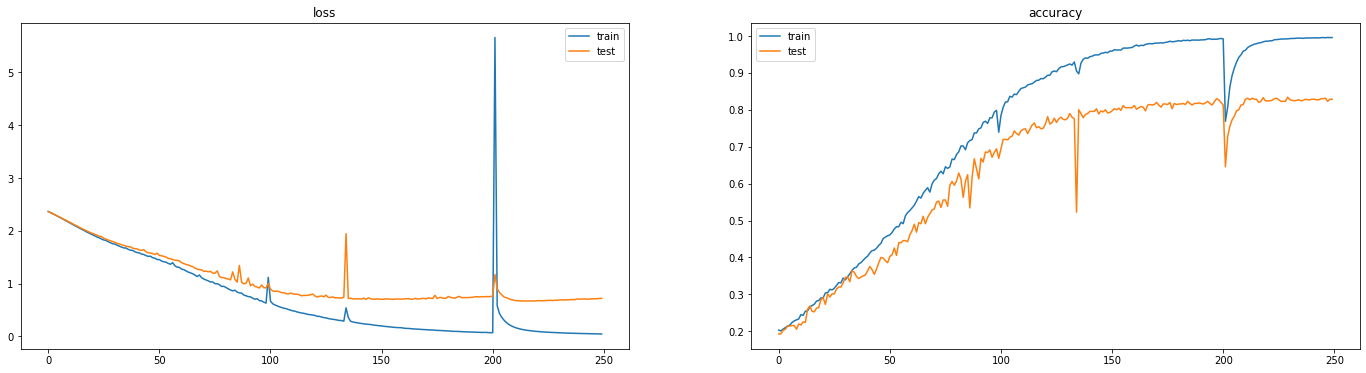

In [ ]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_sparse_categorical_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

In [ ]:
# train using Adam
model = get_word_cnn(vocab_size, max_input_length, num_categories)
model.compile(
    optimizer=adam,
    loss=loss,
    metrics=metrics,
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 20)           736000    
_________________________________________________________________
lambda_1 (Lambda)            (None, 100, 20, 1)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 81, 1, 10)         4010      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 41, 1, 10)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 22, 1, 10)         2010      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 11, 1, 10)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 110)              

In [ ]:
%%time
history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(test_features, test_labels),
    verbose=0,  # too much output may crash the browser
)

CPU times: user 2min 16s, sys: 15.6 s, total: 2min 32s
Wall time: 1min 40s


In [ ]:
%%time
results = model.evaluate(
    x=test_features,
    y=test_labels,
    batch_size=batch_size,
)

6/6 [==============================] - 0s 2ms/step - loss: 2.4015 - sparse_categorical_accuracy: 0.2700
CPU times: user 50 ms, sys: 6.56 ms, total: 56.6 ms
Wall time: 56.2 ms


highest validation accuracy achieved: 0.27714285254478455


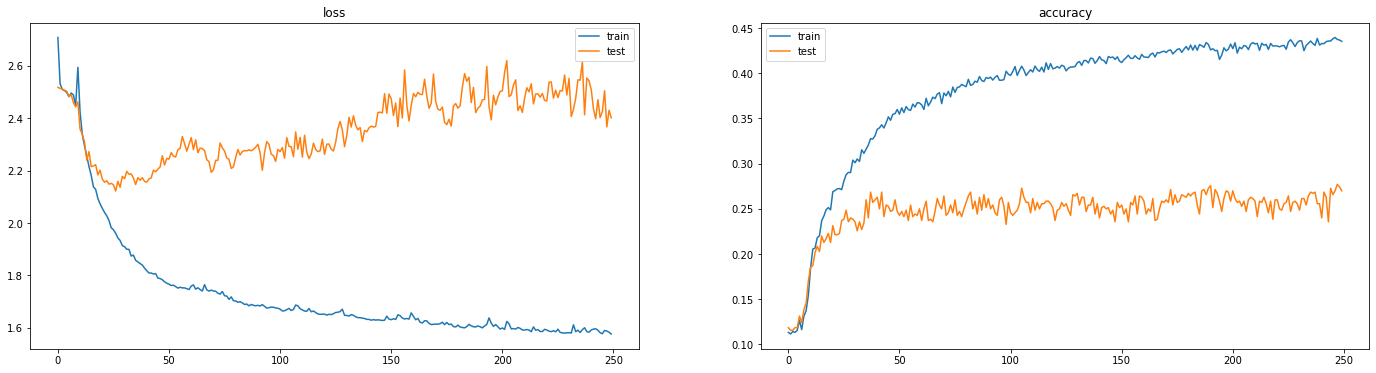

In [ ]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_sparse_categorical_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

# 3. 

Design a Character RNN Classifier that receives character ids and classify the input. The RNN is GRU layer and has a hidden-layer size of 20.


Plot the entropy cost on training data and the accuracy on testing data against training epochs.

In [ ]:
# same as in preprocessing for CNN, but no need to expand_dims
def preprocess_char_data_rnn(train_data_path, test_data_path) -> tuple:
    '''
    Preprocess data for character classification
    '''
    raw_train_features, raw_train_labels = get_data_from_text(train_data_path)
    raw_test_features, raw_test_labels = get_data_from_text(test_data_path)
    
    char_id_map = get_char_id_map(raw_train_features + raw_test_features)

    # give each character an id
    train_features = convert_char_to_id(raw_train_features, char_id_map)
    train_labels = np.array(raw_train_labels)

    test_features = convert_char_to_id(raw_test_features, char_id_map)
    test_labels = np.array(raw_test_labels)

    # convert id to one-hot encoding
    train_features = tf.one_hot(train_features, num_characters)
    test_features = tf.one_hot(test_features, num_characters)

    vocab_size = len(char_id_map.keys())

    return train_features, train_labels, test_features, test_labels, vocab_size

In [ ]:
(
    train_features, train_labels,
    test_features, test_labels,
    vocab_size,
) = preprocess_char_data_rnn(train_data_path, test_data_path)

# print out data info
print(f'vocabulary size: {vocab_size}')

print(f'train features shape: {train_features.shape}')
print(f'train labels shape: {train_labels.shape}')

print(f'test features shape: {test_features.shape}')
print(f'test labels shape: {test_labels.shape}')

vocabulary size: 1173
train features shape: (5600, 100, 256)
train labels shape: (5600,)
test features shape: (700, 100, 256)
test labels shape: (700,)


In [151]:
# design character RNN classifier
def get_character_rnn(
    input_shape: tuple,
    num_categories: int,
    rnn_type: str = 'gru',
    num_rnn_layers: int = 1,
    use_dropout: bool = False,
) -> tf.keras.Sequential:
    '''
    Generates a character RNN classifier.

    :params:
    - input_shape (tuple): shape of the one-hot encoding of input data
    - num_categories (int): number of classes to classify
    - rnn_type (str): type of rnn - 'gru', 'vanilla' or 'lstm' (default: 'gru)
    - num_rnn_layers (int): number of RNN layers (default: 1)
    - use_dropout (bool): whether to use dropout rate of 0.5 (default: False)

    :return:
    - an initial model (tf.keras.Sequential)
    '''    
    if rnn_type not in ('gru', 'vanilla', 'lstm'):
        raise ValueError('invalid RNN type')
    
    if num_rnn_layers < 1:
        raise ValueError('invalid number of RNN layers')

    model = tf.keras.Sequential()

    input_layer = tf.keras.layers.Input(shape=input_shape)
    model.add(input_layer)

    if rnn_type == 'gru':
        cells = [
            tf.keras.layers.GRUCell(
                units=20,
                dropout=0.5 if use_dropout else 0,
            ) for _ in range(num_rnn_layers)
        ]
    elif rnn_type == 'vanilla':
        cells = [
            tf.keras.layers.SimpleRNNCell(
                units=20,
                dropout=0.5 if use_dropout else 0,
            ) for _ in range(num_rnn_layers)
        ]
    elif rnn_type == 'lstm':
       cells = [
            tf.keras.layers.LSTMCell(
                units=20,
                dropout=0.5 if use_dropout else 0,
            ) for _ in range(num_rnn_layers)
        ]

    rnn = tf.keras.layers.RNN(cells, unroll=True)
    model.add(rnn)

    fully_connected = tf.keras.layers.Dense(
        units=num_categories,
        # no need for softmax due to sparse categorical crossentropy loss,
        # according to sample code
    )
    model.add(fully_connected)

    return model

In [ ]:
# train using SGD
model = get_character_rnn(
    input_shape=(max_input_length, num_characters),
    num_categories=num_categories,
)
model.compile(
    optimizer=sgd,
    loss=loss,
    metrics=metrics,
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 20)                16680     
_________________________________________________________________
dense_4 (Dense)              (None, 15)                315       
Total params: 16,995
Trainable params: 16,995
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(test_features, test_labels),
    verbose=0,  # too much output may crash browser
)

CPU times: user 2min 42s, sys: 6.7 s, total: 2min 49s
Wall time: 2min 6s


In [ ]:
%%time
results = model.evaluate(
    x=test_features,
    y=test_labels,
    batch_size=batch_size,
)

6/6 [==============================] - 0s 6ms/step - loss: 2.6075 - sparse_categorical_accuracy: 0.1100
CPU times: user 109 ms, sys: 5.95 ms, total: 115 ms
Wall time: 94.2 ms


highest validation accuracy achieved: 0.1128571406006813


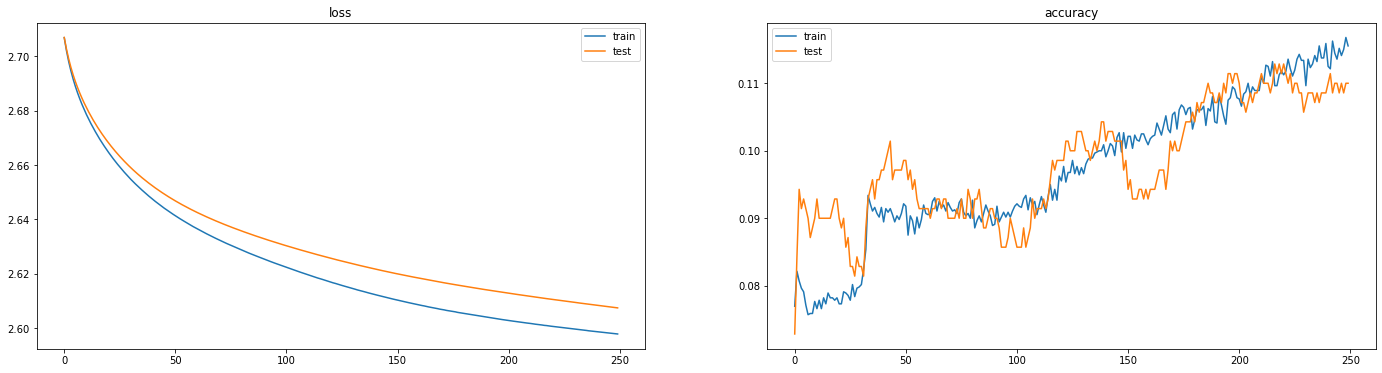

In [ ]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_sparse_categorical_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

In [ ]:
# train using Adam
model = get_character_rnn(
    input_shape=(max_input_length, num_characters),
    num_categories=num_categories,
)
model.compile(
    optimizer=adam,
    loss=loss,
    metrics=metrics,
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 20)                16680     
_________________________________________________________________
dense_5 (Dense)              (None, 15)                315       
Total params: 16,995
Trainable params: 16,995
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(test_features, test_labels),
    verbose=0, # too much output may crash the browser
)

CPU times: user 2min 42s, sys: 11 s, total: 2min 53s
Wall time: 2min 10s


In [ ]:
%%time
results = model.evaluate(
    x=test_features,
    y=test_labels,
    batch_size=batch_size,
)

6/6 [==============================] - 0s 7ms/step - loss: 2.4683 - sparse_categorical_accuracy: 0.6357
CPU times: user 112 ms, sys: 10.1 ms, total: 123 ms
Wall time: 113 ms


highest validation accuracy achieved: 0.6871428489685059


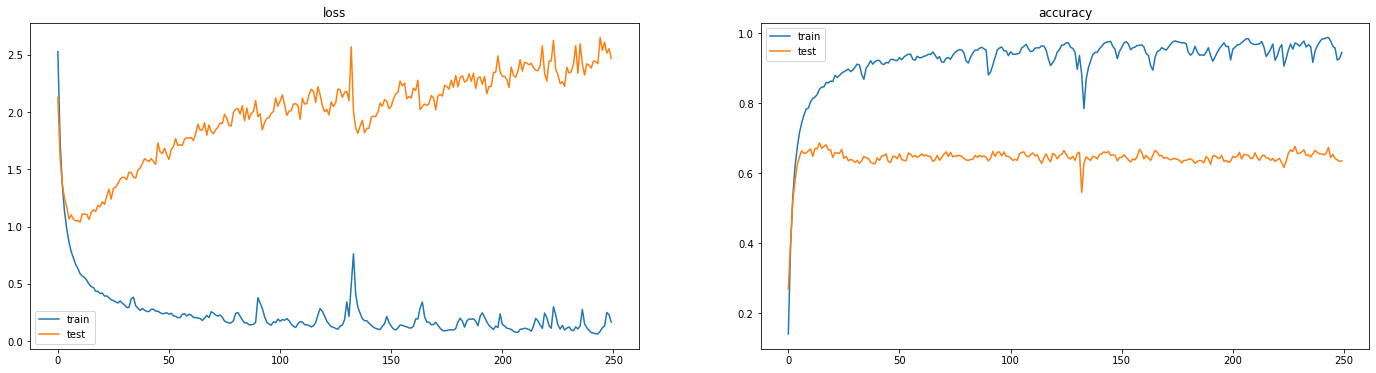

In [ ]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_sparse_categorical_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

# 4. 

Design a word RNN classifier that receives word ids and classify the input. The RNN is GRU layer and has a hidden-layer size of 20. Pass the inputs through an embedding layer of size 20 before feeding to the RNN.


Plot the entropy on training data and the accuracy on testing data versus training epochs.

In [ ]:
# reference: https://www.tensorflow.org/tutorials/keras/text_classification
# reference: https://www.tensorflow.org/tutorials/text/text_classification_rnn
def preprocess_word_data_rnn(train_data_path, test_data_path) -> tuple:
    raw_train_features, raw_train_labels = get_data_from_text(train_data_path)
    raw_test_features, raw_test_labels = get_data_from_text(test_data_path)

    raw_train_ds = tf.data.Dataset.from_tensor_slices((
        raw_train_features,
        raw_train_labels,
    )).batch(batch_size)

    raw_test_ds = tf.data.Dataset.from_tensor_slices((
        raw_test_features,
        raw_test_labels,
    )).batch(batch_size)

    vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
        output_sequence_length=max_input_length,
    )

    vectorize_layer.adapt(raw_train_features + raw_test_features)

    # need vocab size for RNN design later
    vocab_size = len(vectorize_layer.get_vocabulary())

    def vectorize(features, labels):
        features = tf.expand_dims(features, axis=-1)
        return vectorize_layer(features), labels

    train_ds = raw_train_ds.map(vectorize)
    test_ds = raw_test_ds.map(vectorize)

    train_ds = train_ds.cache()
    test_ds = test_ds.cache()

    return train_ds, test_ds, vocab_size

In [ ]:
train_ds, test_ds, vocab_size = preprocess_word_data_rnn(
    train_data_path,
    test_data_path,
)
print(f'vocabulary size: {vocab_size}')

vocabulary size: 39602


In [145]:
# design word RNN classifier
def get_word_rnn(
    vocab_size: int,
    max_input_length: int,
    num_categories: int,
    rnn_type: str = 'gru',
    num_rnn_layers: int = 1,
    use_dropout: bool = False,
) -> tf.keras.Sequential:
    '''
    Generates a word RNN classifier.

    :params:
    - vocab_size (int): vocabulary size
    - max_input_length (int): maximum length of input
    - num_categories (int): number of classes to classify
    - rnn_type (str): type of rnn - 'gru', 'vanilla' or 'lstm' (default: 'gru)
    - num_rnn_layers (int): 1 or 2 RNN layers (default: 1)
    - use_dropout (bool): whether to use dropout rate of 0.5 (default: False)

    :return:
    - an initial model (tf.keras.Sequential)
    '''    
    if rnn_type not in ('gru', 'vanilla', 'lstm'):
        raise ValueError('invalid RNN type')
    
    if num_rnn_layers < 1 or num_rnn_layers > 2:
        raise ValueError('invalid number of RNN layers')

    model = tf.keras.Sequential()

    embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=20,  # embedding_size
        input_length=max_input_length,
    )
    model.add(embedding)

    if rnn_type == 'gru':
        cells = [
            tf.keras.layers.GRUCell(
                units=20,
                dropout=0.5 if use_dropout else 0,
            ) for _ in range(num_rnn_layers)
        ]
    elif rnn_type == 'vanilla':
        cells = [
            tf.keras.layers.SimpleRNNCell(
                units=20,
                dropout=0.5 if use_dropout else 0,
            ) for _ in range(num_rnn_layers)
        ]
    elif rnn_type == 'lstm':
       cells = [
            tf.keras.layers.LSTMCell(
                units=20,
                dropout=0.5 if use_dropout else 0,
            ) for _ in range(num_rnn_layers)
        ]

    rnn = tf.keras.layers.RNN(cells, unroll=True)
    model.add(rnn)

    fully_connected = tf.keras.layers.Dense(
        units=num_categories,
        # no need for softmax due to sparse categorical crossentropy loss,
        # according to sample code
    )
    model.add(fully_connected)

    return model

In [ ]:
# try training with SGD
model = get_word_rnn(vocab_size, max_input_length, num_categories)
model.compile(
    optimizer=sgd,
    loss=loss,
    metrics=metrics,
)

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 20)           792040    
_________________________________________________________________
gru_2 (GRU)                  (None, 20)                2520      
_________________________________________________________________
dense_6 (Dense)              (None, 15)                315       
Total params: 794,875
Trainable params: 794,875
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=test_ds,
    verbose=0,  # too much output may crash browser
)

CPU times: user 1min 35s, sys: 7.4 s, total: 1min 42s
Wall time: 1min 21s


In [ ]:
%%time
results = model.evaluate(test_ds, batch_size=batch_size)

6/6 [==============================] - 0s 4ms/step - loss: 2.6402 - sparse_categorical_accuracy: 0.0714
CPU times: user 59.3 ms, sys: 2.05 ms, total: 61.3 ms
Wall time: 55 ms


highest validation accuracy achieved: 0.07285714149475098


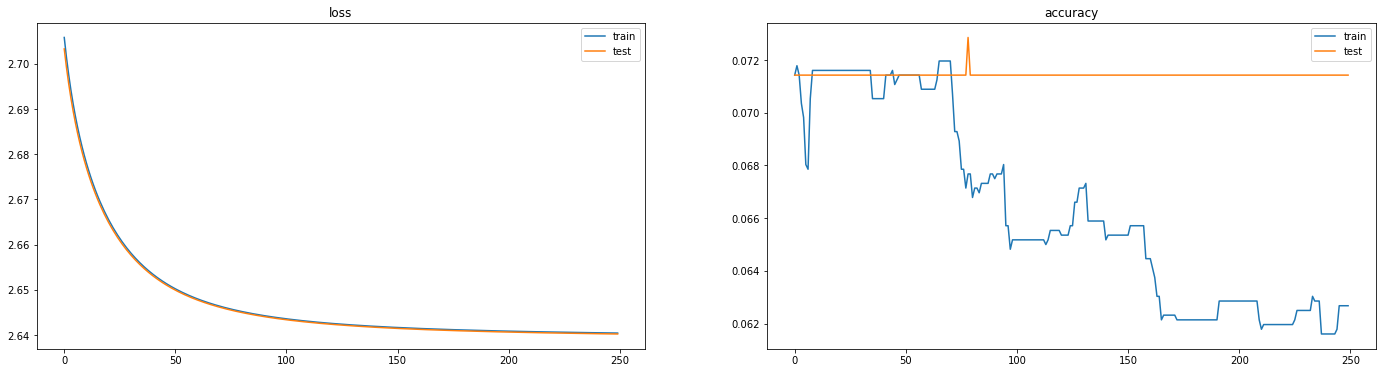

In [ ]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_sparse_categorical_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

In [ ]:
# try training with Adam
model = get_word_rnn(vocab_size, max_input_length, num_categories)
model.compile(
    optimizer=adam,
    loss=loss,
    metrics=metrics,
)

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 20)           792040    
_________________________________________________________________
gru_3 (GRU)                  (None, 20)                2520      
_________________________________________________________________
dense_7 (Dense)              (None, 15)                315       
Total params: 794,875
Trainable params: 794,875
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=test_ds,
    verbose=0,  # too much output may crash the browser
)

CPU times: user 3min 12s, sys: 1min 6s, total: 4min 19s
Wall time: 3min 1s


In [ ]:
%%time
results = model.evaluate(test_ds, batch_size=batch_size)

6/6 [==============================] - 0s 3ms/step - loss: 1.1171 - sparse_categorical_accuracy: 0.8557
CPU times: user 56.7 ms, sys: 3.74 ms, total: 60.5 ms
Wall time: 54.2 ms


highest validation accuracy achieved: 0.8799999952316284


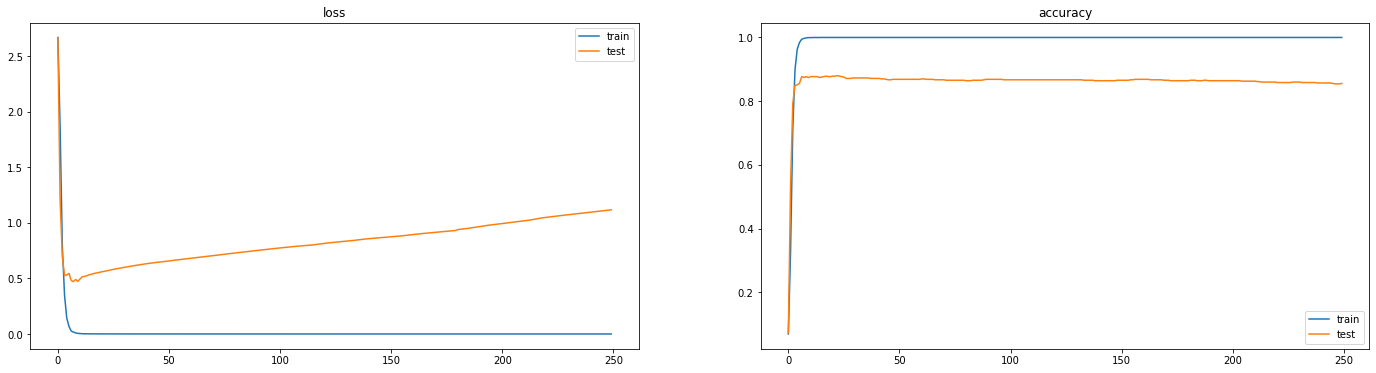

In [ ]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_sparse_categorical_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

# 5.

Compare the test accuracies and the running times of the networks implemented in parts (1) – (4).


Experiment with adding dropout to the layers of networks in parts (1) – (4), and report the test accuracies. Compare and comment on the accuracies of the networks with/without dropout.

Comparison of the test accuracies and the running times of the networks implemented in parts (1) – (4)

using SGD:

network\metric|test accuracy|training time|evaluation time
-|-|-|-
character CNN|0.671428|2min 15s|102 ms
word CNN|0.834285|54.2 s|59.2 ms
character RNN|0.112857|2min 42s|109 ms
word RNN|0.072857|1min 35s|59.3 ms

using Adam:

network\metric|test accuracy|training time|evaluation time
-|-|-|-
character CNN|0.600000|2min 12s|101 ms
word CNN|0.277142|2min 16s|50 ms
character RNN|0.687142|2min 42s|112 ms
word RNN|0.879999|3min 12s|56.7 ms

In [ ]:
# 1. character CNN, with dropout
(
    train_features, train_labels,
    test_features, test_labels,
    vocab_size,
) = preprocess_char_data_cnn(train_data_path, test_data_path)

In [ ]:
# 1a. train using SGD
model = get_character_cnn(
    input_shape=(max_input_length, num_characters, 1),
    num_categories=num_categories,
    use_dropout=True,
)
model.compile(
    optimizer=sgd,
    loss=loss,
    metrics=metrics,
)

In [ ]:
%%time
history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(test_features, test_labels),
    verbose=0,  # too much output may crash browser
)

CPU times: user 2min 18s, sys: 9.52 s, total: 2min 27s
Wall time: 2min 24s


In [ ]:
%%time
results = model.evaluate(
    x=test_features,
    y=test_labels,
    batch_size=batch_size,
)

6/6 [==============================] - 0s 8ms/step - loss: 1.3202 - sparse_categorical_accuracy: 0.6743
CPU times: user 105 ms, sys: 3.94 ms, total: 109 ms
Wall time: 113 ms


highest validation accuracy achieved: 0.6871428489685059


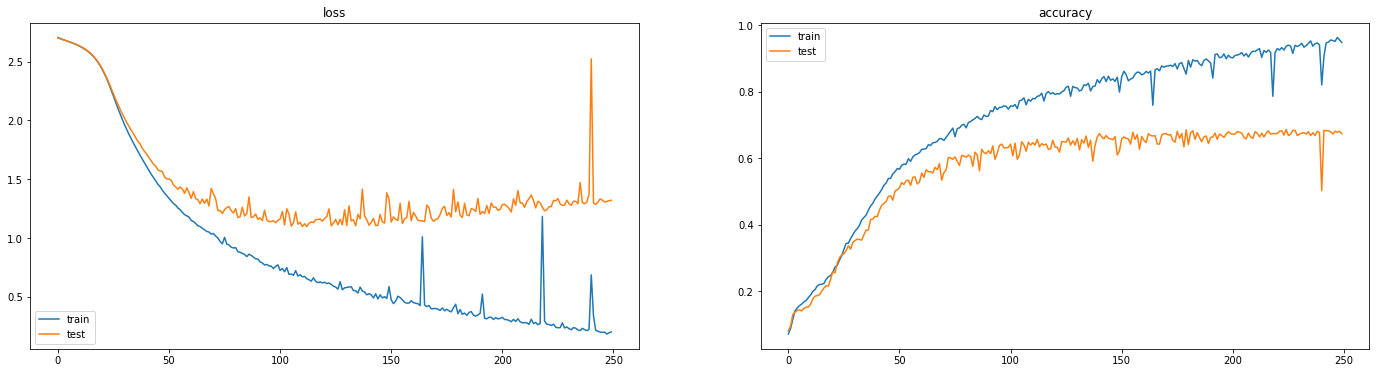

In [ ]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_sparse_categorical_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

In [ ]:
# 1b. train using Adam
model = get_character_cnn(
    input_shape=(max_input_length, num_characters, 1),
    num_categories=num_categories,
    use_dropout=True,
)
model.compile(
    optimizer=adam,
    loss=loss,
    metrics=metrics,
)

In [ ]:
%%time
history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(test_features, test_labels),
    verbose=0,  # too much output may crash browser
)

CPU times: user 2min 15s, sys: 9.17 s, total: 2min 24s
Wall time: 2min 24s


In [ ]:
%%time
results = model.evaluate(
    x=test_features,
    y=test_labels,
    batch_size=batch_size,
)

6/6 [==============================] - 0s 9ms/step - loss: 6.2190 - sparse_categorical_accuracy: 0.2314
CPU times: user 105 ms, sys: 10.9 ms, total: 116 ms
Wall time: 119 ms


highest validation accuracy achieved: 0.2542857229709625


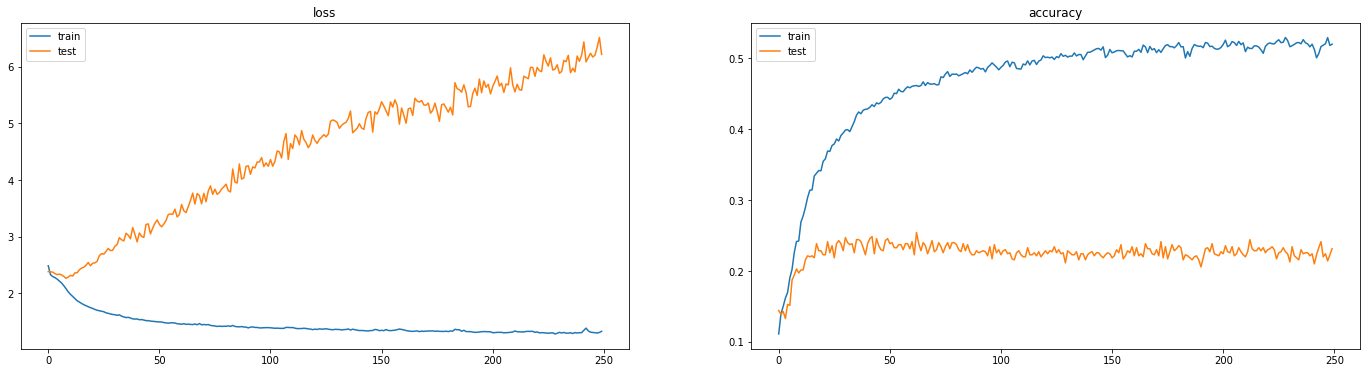

In [ ]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_sparse_categorical_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

In [ ]:
# 2. word CNN, with dropout
(
    train_features, train_labels,
    test_features, test_labels,
    vocab_size,
) = preprocess_word_data_cnn(
    train_data_path,
    test_data_path,
)

In [ ]:
# 2a. train using SGD
model = get_word_cnn(
    vocab_size,
    max_input_length,
    num_categories,
    use_dropout=True,
)
model.compile(
    optimizer=sgd,
    loss=loss,
    metrics=metrics,
)

In [ ]:
%%time
history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(test_features, test_labels),
    verbose=0,  # too much output may crash browser
)

CPU times: user 54.1 s, sys: 7.22 s, total: 1min 1s
Wall time: 51.1 s


In [ ]:
%%time
results = model.evaluate(
    x=test_features,
    y=test_labels,
    batch_size=batch_size,
)

6/6 [==============================] - 0s 3ms/step - loss: 1.3164 - sparse_categorical_accuracy: 0.5386
CPU times: user 68 ms, sys: 3.3 ms, total: 71.3 ms
Wall time: 73.1 ms


highest validation accuracy achieved: 0.5542857050895691


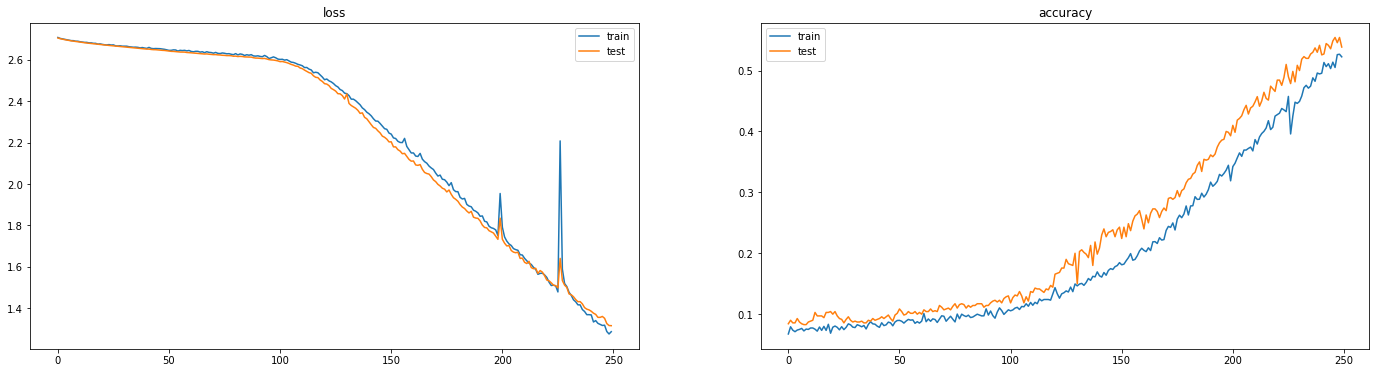

In [ ]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_sparse_categorical_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

In [ ]:
# 2b. train using Adam
model = get_word_cnn(
    vocab_size,
    max_input_length,
    num_categories,
    use_dropout=True,
)
model.compile(
    optimizer=adam,
    loss=loss,
    metrics=metrics,
)

In [ ]:
%%time
history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(test_features, test_labels),
    verbose=0,  # too much output may crash browser
)

CPU times: user 2min 16s, sys: 14 s, total: 2min 31s
Wall time: 1min 39s


In [ ]:
%%time
results = model.evaluate(
    x=test_features,
    y=test_labels,
    batch_size=batch_size,
)

6/6 [==============================] - 0s 3ms/step - loss: 2.6391 - sparse_categorical_accuracy: 0.0714
CPU times: user 59.1 ms, sys: 5.18 ms, total: 64.2 ms
Wall time: 61.7 ms


highest validation accuracy achieved: 0.0714285746216774


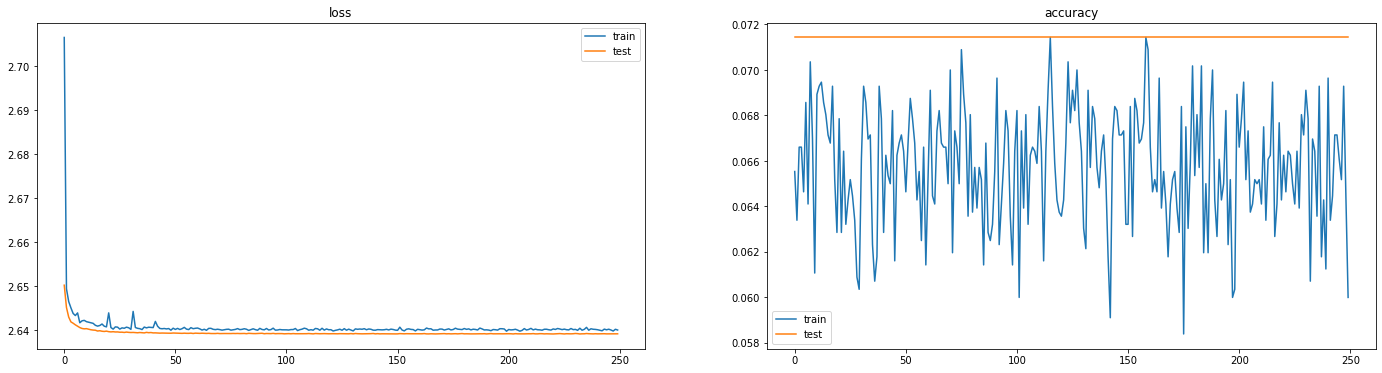

In [ ]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_sparse_categorical_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

In [ ]:
# 3. character RNN, with dropout
(
    train_features, train_labels,
    test_features, test_labels,
    vocab_size,
) = preprocess_char_data_rnn(train_data_path, test_data_path)

In [ ]:
# 3a. train using SGD
model = get_character_rnn(
    input_shape=(max_input_length, num_characters),
    num_categories=num_categories,
    use_dropout=True,
)
model.compile(
    optimizer=sgd,
    loss=loss,
    metrics=metrics,
)

In [ ]:
%%time
history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(test_features, test_labels),
    verbose=0,  # too much output may crash browser
)

CPU times: user 2min 47s, sys: 7.26 s, total: 2min 54s
Wall time: 2min 12s


In [ ]:
%%time
results = model.evaluate(
    x=test_features,
    y=test_labels,
    batch_size=batch_size,
)

6/6 [==============================] - 0s 7ms/step - loss: 2.6147 - sparse_categorical_accuracy: 0.1100
CPU times: user 112 ms, sys: 5.73 ms, total: 118 ms
Wall time: 99.5 ms


highest validation accuracy achieved: 0.10999999940395355


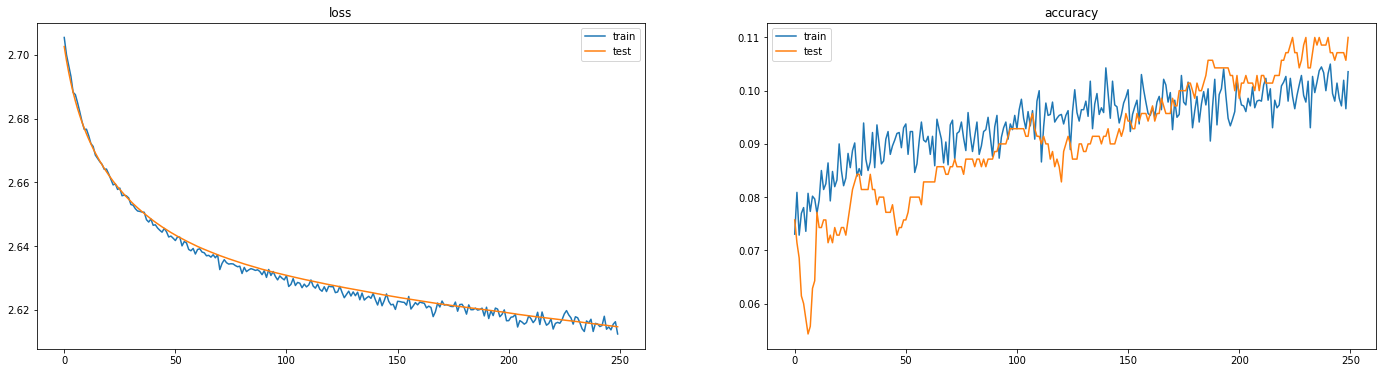

In [ ]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_sparse_categorical_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

In [ ]:
# 3b. train using Adam
model = get_character_rnn(
    input_shape=(max_input_length, num_characters),
    num_categories=num_categories,
    use_dropout=True,
)
model.compile(
    optimizer=adam,
    loss=loss,
    metrics=metrics,
)

In [ ]:
%%time
history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(test_features, test_labels),
    verbose=0,  # too much output may crash browser
)

CPU times: user 2min 47s, sys: 6.88 s, total: 2min 53s
Wall time: 2min 16s


In [ ]:
%%time
results = model.evaluate(
    x=test_features,
    y=test_labels,
    batch_size=batch_size,
)

6/6 [==============================] - 0s 7ms/step - loss: 1.3066 - sparse_categorical_accuracy: 0.6243
CPU times: user 106 ms, sys: 6.85 ms, total: 113 ms
Wall time: 95.3 ms


highest validation accuracy achieved: 0.6585714221000671


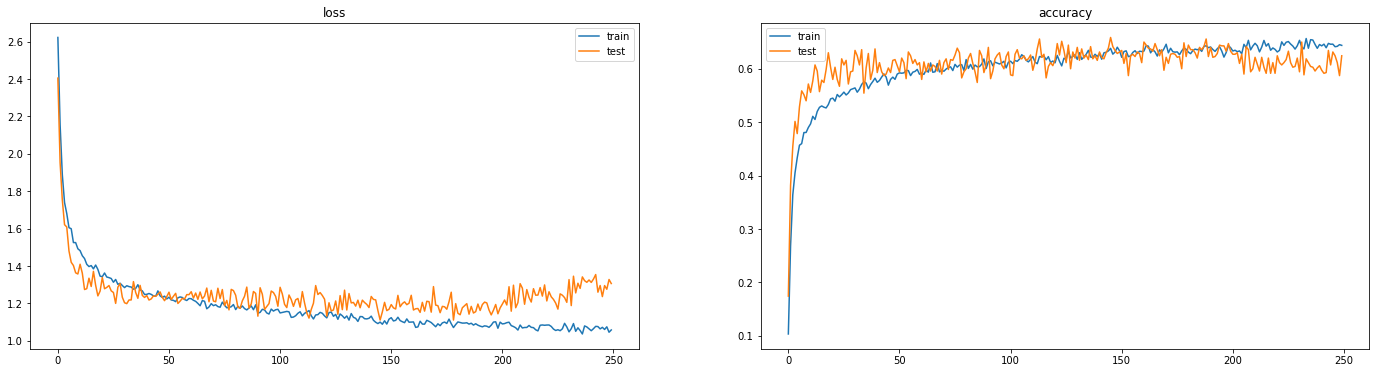

In [ ]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_sparse_categorical_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

In [ ]:
# 4. word RNN, with dropout
train_ds, test_ds, vocab_size = preprocess_word_data_rnn(
    train_data_path,
    test_data_path,
)

In [ ]:
# 4a. try training with SGD
model = get_word_rnn(
    vocab_size,
    max_input_length,
    num_categories,
    use_dropout=True,
)
model.compile(
    optimizer=sgd,
    loss=loss,
    metrics=metrics,
)

In [ ]:
%%time
history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=test_ds,
    verbose=0,  # too much output may crash browser
)

CPU times: user 1min 39s, sys: 7.87 s, total: 1min 47s
Wall time: 1min 24s


In [ ]:
%%time
results = model.evaluate(test_ds, batch_size=batch_size)

6/6 [==============================] - 0s 4ms/step - loss: 2.6402 - sparse_categorical_accuracy: 0.0714
CPU times: user 66.6 ms, sys: 239 µs, total: 66.8 ms
Wall time: 60.7 ms


highest validation accuracy achieved: 0.07285714149475098


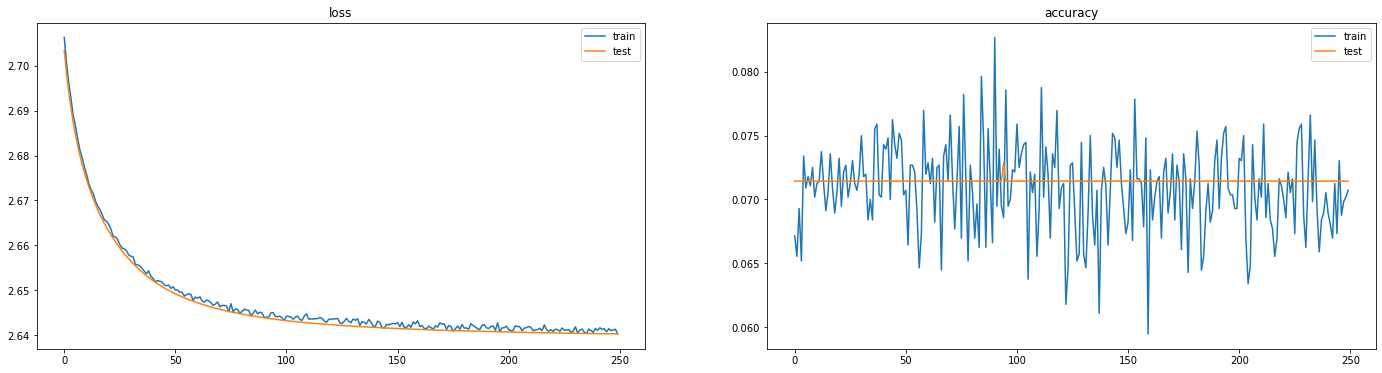

In [ ]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_sparse_categorical_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

In [ ]:
# 4b. try training with Adam
model = get_word_rnn(
    vocab_size,
    max_input_length,
    num_categories,
    use_dropout=True,
)
model.compile(
    optimizer=adam,
    loss=loss,
    metrics=metrics,
)

In [ ]:
%%time
history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=test_ds,
    verbose=0,  # too much output may crash browser
)

CPU times: user 3min 21s, sys: 16.8 s, total: 3min 38s
Wall time: 2min 33s


In [ ]:
%%time
results = model.evaluate(test_ds, batch_size=batch_size)

6/6 [==============================] - 0s 4ms/step - loss: 0.3665 - sparse_categorical_accuracy: 0.9229
CPU times: user 55.2 ms, sys: 8.11 ms, total: 63.3 ms
Wall time: 56.3 ms


highest validation accuracy achieved: 0.9357143044471741


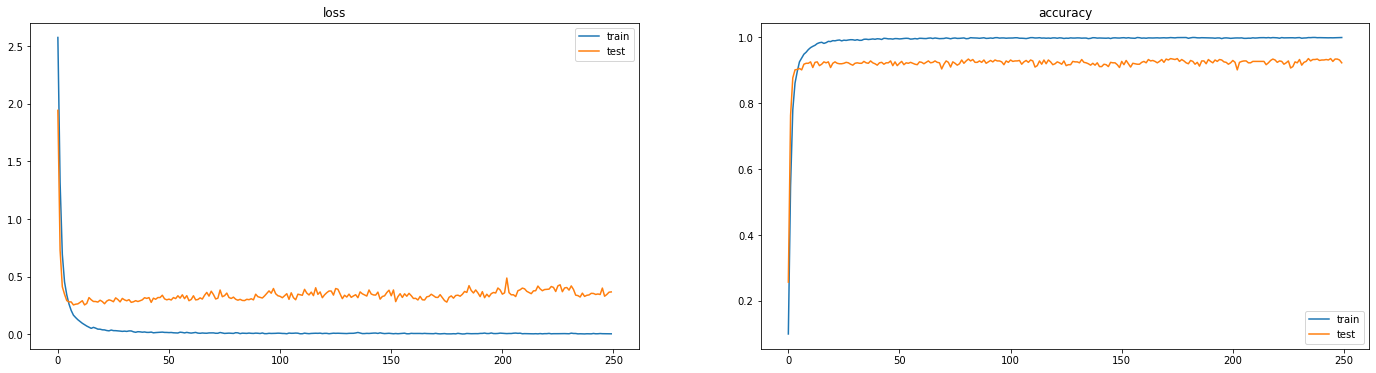

In [ ]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_sparse_categorical_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

Experiment with adding dropout to the layers of networks in parts (1) – (4), and report the test accuracies.

dropout accuracies:

network\metric|test accuracy (SGD)|test accuracy (Adam)
-|-|-
character CNN|0.687142|0.254285
word CNN|0.554285|0.071428
character RNN|0.109999|0.658571
word RNN|0.072857|0.935714


Compare and comment on the accuracies of the networks
with/without dropout.

using SGD:

network\metric|test accuracy (without dropout)|test accuracy (with dropout)
-|-|-
character CNN|0.671428|0.687142
word CNN|0.834285|0.554285
character RNN|0.112857|0.109999
word RNN|0.072857|0.072857

using Adam:

network\metric|test accuracy (without dropout)|test accuracy (with dropout)
-|-|-
character CNN|0.600000|0.254285
word CNN|0.277142|0.071428
character RNN|0.687142|0.658571
word RNN|0.879999|0.935714

# 6. 

For RNN networks implemented in (3) and (4), perform the following experiments with the aim of improving performances, compare the accuracies and report your findings:

1. Replace the GRU layer with (i) a vanilla RNN layer and (ii) a LSTM layer
2. Increase the number of RNN layers to 2 layers
3. Add gradient clipping to RNN training with clipping threshold = 2.

In [ ]:
# use Adam optimizer since it is better for RNN (at least for GRU)
# assumptions: hyperparameter tuning is independent

In [112]:
# preprocessing of data for character RNN
(
    train_features, train_labels,
    test_features, test_labels,
    vocab_size,
) = preprocess_char_data_rnn(train_data_path, test_data_path)

In [113]:
# 6ai. Replace the GRU layer with a vanilla RNN layer
# for character RNN
model = get_character_rnn(
    input_shape=(max_input_length, num_characters),
    num_categories=num_categories,
    rnn_type='vanilla',
)
model.compile(
    optimizer=adam,
    loss=loss,
    metrics=metrics,
)

model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 20)                5540      
_________________________________________________________________
dense_20 (Dense)             (None, 15)                315       
Total params: 5,855
Trainable params: 5,855
Non-trainable params: 0
_________________________________________________________________


In [114]:
%%time
history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(test_features, test_labels),
    verbose=0,  # too much output may crash browser
)

CPU times: user 16min 47s, sys: 2min 15s, total: 19min 2s
Wall time: 10min 49s


In [115]:
%%time
results = model.evaluate(
    x=test_features,
    y=test_labels,
    batch_size=batch_size,
)

6/6 [==============================] - 0s 11ms/step - loss: 2.6687 - sparse_categorical_accuracy: 0.0843
CPU times: user 134 ms, sys: 9.64 ms, total: 144 ms
Wall time: 130 ms


highest validation accuracy achieved: 0.1485714316368103


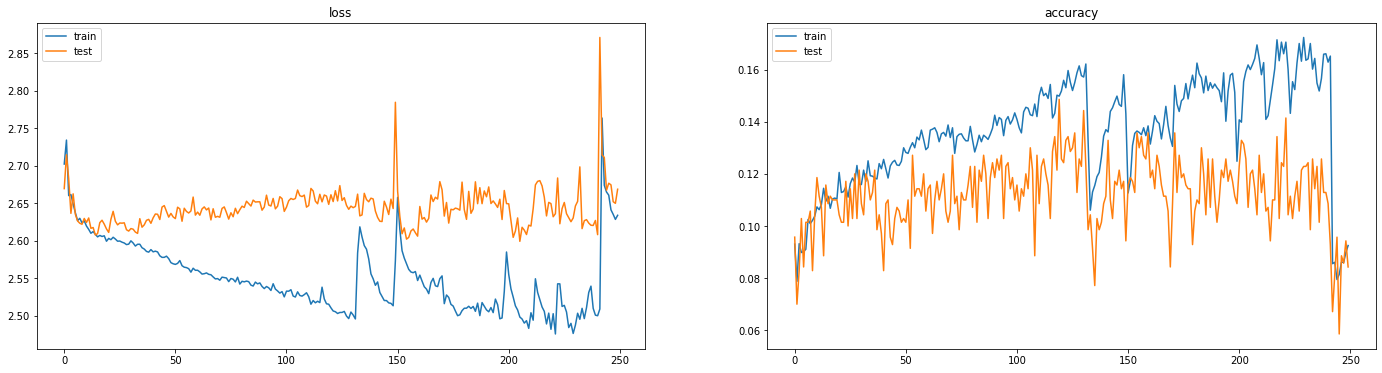

In [116]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_sparse_categorical_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

In [117]:
# 6aii. Replace the GRU layer with a LSTM layer
# for character RNN
model = get_character_rnn(
    input_shape=(max_input_length, num_characters),
    num_categories=num_categories,
    rnn_type='lstm',
)
model.compile(
    optimizer=adam,
    loss=loss,
    metrics=metrics,
)

model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                22160     
_________________________________________________________________
dense_21 (Dense)             (None, 15)                315       
Total params: 22,475
Trainable params: 22,475
Non-trainable params: 0
_________________________________________________________________


In [118]:
%%time
history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(test_features, test_labels),
    verbose=0,  # too much output may crash browser
)

CPU times: user 2min 39s, sys: 6.03 s, total: 2min 45s
Wall time: 2min 1s


In [119]:
%%time
results = model.evaluate(
    x=test_features,
    y=test_labels,
    batch_size=batch_size,
)

6/6 [==============================] - 0s 6ms/step - loss: 2.4885 - sparse_categorical_accuracy: 0.6457
CPU times: user 107 ms, sys: 4.07 ms, total: 111 ms
Wall time: 90.3 ms


highest validation accuracy achieved: 0.6942856907844543


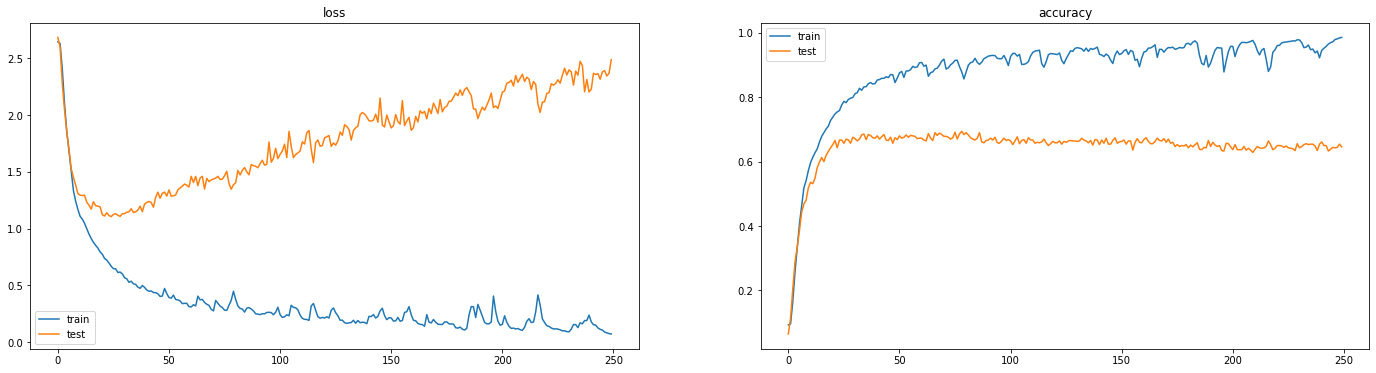

In [120]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_sparse_categorical_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

In [152]:
# 6b. Increase the number of RNN layers to 2 layers
# for character RNN
model = get_character_rnn(
    input_shape=(max_input_length, num_characters),
    num_categories=num_categories,
    num_rnn_layers=2,
)
model.compile(
    optimizer=adam,
    loss=loss,
    metrics=metrics,
)

model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_2 (RNN)                  (None, 20)                19200     
_________________________________________________________________
dense_28 (Dense)             (None, 15)                315       
Total params: 19,515
Trainable params: 19,515
Non-trainable params: 0
_________________________________________________________________


In [153]:
%%time
history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(test_features, test_labels),
)

Epoch 1/250
44/44 [==============================] - 8s 174ms/step - loss: 2.6050 - sparse_categorical_accuracy: 0.1025 - val_loss: 2.2232 - val_sparse_categorical_accuracy: 0.2043
Epoch 2/250
44/44 [==============================] - 4s 81ms/step - loss: 1.6599 - sparse_categorical_accuracy: 0.4302 - val_loss: 1.3728 - val_sparse_categorical_accuracy: 0.4914
Epoch 3/250
44/44 [==============================] - 4s 81ms/step - loss: 1.1353 - sparse_categorical_accuracy: 0.6136 - val_loss: 1.0299 - val_sparse_categorical_accuracy: 0.6371
Epoch 4/250
44/44 [==============================] - 3s 79ms/step - loss: 0.9024 - sparse_categorical_accuracy: 0.7027 - val_loss: 0.9580 - val_sparse_categorical_accuracy: 0.6586
Epoch 5/250
44/44 [==============================] - 4s 81ms/step - loss: 0.7466 - sparse_categorical_accuracy: 0.7598 - val_loss: 0.9043 - val_sparse_categorical_accuracy: 0.6943
Epoch 6/250
44/44 [==============================] - 4s 80ms/step - loss: 0.6321 - sparse_categoric

In [154]:
%%time
results = model.evaluate(
    x=test_features,
    y=test_labels,
    batch_size=batch_size,
)

6/6 [==============================] - 0s 26ms/step - loss: 2.0603 - sparse_categorical_accuracy: 0.7386
CPU times: user 251 ms, sys: 11.8 ms, total: 263 ms
Wall time: 234 ms


highest validation accuracy achieved: 0.7599999904632568


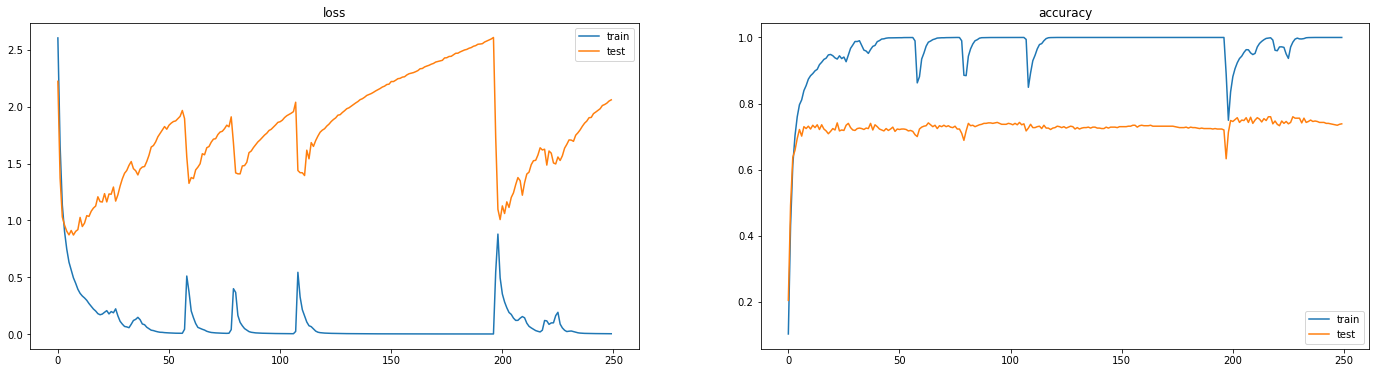

In [155]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_sparse_categorical_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

In [122]:
# 6c. Add gradient clipping to RNN training with clipping threshold = 2.
# for character RNN
model = get_character_rnn(
    input_shape=(max_input_length, num_characters),
    num_categories=num_categories,
)

adam_clip = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    clipvalue=2,
)
model.compile(
    optimizer=adam_clip,
    loss=loss,
    metrics=metrics,
)

model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_10 (GRU)                 (None, 20)                16680     
_________________________________________________________________
dense_22 (Dense)             (None, 15)                315       
Total params: 16,995
Trainable params: 16,995
Non-trainable params: 0
_________________________________________________________________


In [123]:
%%time
history = model.fit(
    x=train_features,
    y=train_labels,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=(test_features, test_labels),
    verbose=0,  # too much output may crash browser
)

CPU times: user 2min 39s, sys: 6.12 s, total: 2min 45s
Wall time: 2min 4s


In [124]:
%%time
results = model.evaluate(
    x=test_features,
    y=test_labels,
    batch_size=batch_size,
)

6/6 [==============================] - 0s 6ms/step - loss: 1.9549 - sparse_categorical_accuracy: 0.6829
CPU times: user 109 ms, sys: 5.93 ms, total: 115 ms
Wall time: 104 ms


highest validation accuracy achieved: 0.7285714149475098


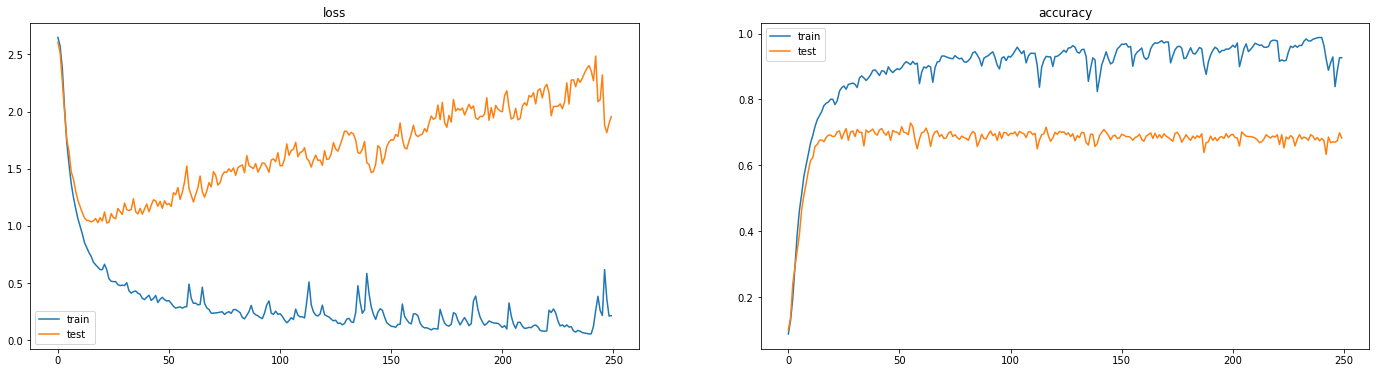

In [125]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_sparse_categorical_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

In [126]:
# preprocessing of data for word RNN
train_ds, test_ds, vocab_size = preprocess_word_data_rnn(
    train_data_path,
    test_data_path,
)

In [127]:
# 6ai. Replace the GRU layer with a vanilla RNN layer
# for word RNN
model = get_word_rnn(
    vocab_size,
    max_input_length,
    num_categories,
    rnn_type='vanilla',
)
model.compile(
    optimizer=adam,
    loss=loss,
    metrics=metrics,
)

model.summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 20)           792040    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 20)                820       
_________________________________________________________________
dense_23 (Dense)             (None, 15)                315       
Total params: 793,175
Trainable params: 793,175
Non-trainable params: 0
_________________________________________________________________


In [128]:
%%time
history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=test_ds,
    verbose=0,  # too much output may crash browser
)

CPU times: user 18min 54s, sys: 2min 25s, total: 21min 19s
Wall time: 12min 24s


In [129]:
%%time
results = model.evaluate(test_ds, batch_size=batch_size)

6/6 [==============================] - 0s 7ms/step - loss: 2.6142 - sparse_categorical_accuracy: 0.0886
CPU times: user 80.8 ms, sys: 4.97 ms, total: 85.7 ms
Wall time: 77.8 ms


highest validation accuracy achieved: 0.09714286029338837


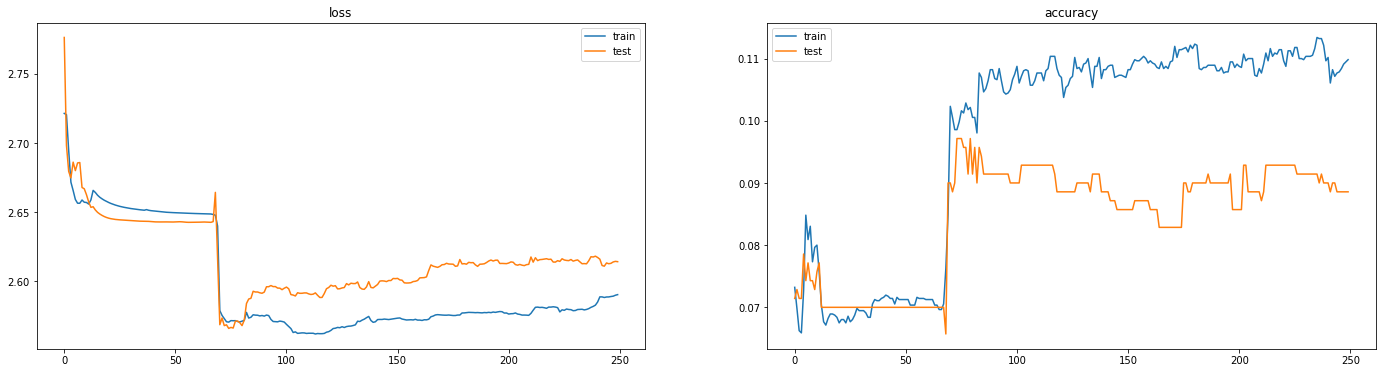

In [130]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_sparse_categorical_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

In [131]:
# 6aii. Replace the GRU layer with a LSTM layer
# for word RNN
model = get_word_rnn(
    vocab_size,
    max_input_length,
    num_categories,
    rnn_type='lstm',
)
model.compile(
    optimizer=adam,
    loss=loss,
    metrics=metrics,
)

model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 20)           792040    
_________________________________________________________________
lstm_2 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense_24 (Dense)             (None, 15)                315       
Total params: 795,635
Trainable params: 795,635
Non-trainable params: 0
_________________________________________________________________


In [132]:
%%time
history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=test_ds,
    verbose=0,  # too much output may crash browser
)

CPU times: user 3min 4s, sys: 11.7 s, total: 3min 15s
Wall time: 2min 21s


In [133]:
%%time
results = model.evaluate(test_ds, batch_size=batch_size)

6/6 [==============================] - 0s 4ms/step - loss: 2.6408 - sparse_categorical_accuracy: 0.0714
CPU times: user 65.7 ms, sys: 3.94 ms, total: 69.7 ms
Wall time: 62.6 ms


highest validation accuracy achieved: 0.0714285746216774


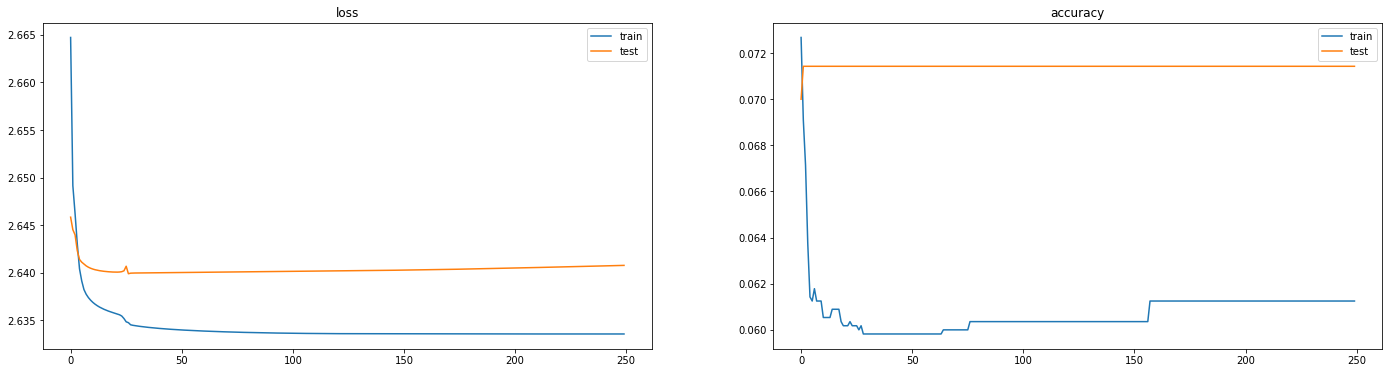

In [134]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_sparse_categorical_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

In [146]:
# 6b. Increase the number of RNN layers to 2 layers
# for word RNN
model = get_word_rnn(
    vocab_size,
    max_input_length,
    num_categories,
    num_rnn_layers=2,
)
model.compile(
    optimizer=adam,
    loss=loss,
    metrics=metrics,
)

model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 20)           792040    
_________________________________________________________________
rnn_1 (RNN)                  (None, 20)                5040      
_________________________________________________________________
dense_27 (Dense)             (None, 15)                315       
Total params: 797,395
Trainable params: 797,395
Non-trainable params: 0
_________________________________________________________________


In [147]:
%%time
history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=test_ds,
)

Epoch 1/250
44/44 [==============================] - 8s 190ms/step - loss: 2.6694 - sparse_categorical_accuracy: 0.0702 - val_loss: 2.6532 - val_sparse_categorical_accuracy: 0.0729
Epoch 2/250
44/44 [==============================] - 4s 92ms/step - loss: 2.4940 - sparse_categorical_accuracy: 0.1123 - val_loss: 2.0256 - val_sparse_categorical_accuracy: 0.1957
Epoch 3/250
44/44 [==============================] - 4s 93ms/step - loss: 1.3650 - sparse_categorical_accuracy: 0.4988 - val_loss: 0.9598 - val_sparse_categorical_accuracy: 0.6957
Epoch 4/250
44/44 [==============================] - 4s 93ms/step - loss: 0.5396 - sparse_categorical_accuracy: 0.8377 - val_loss: 0.5459 - val_sparse_categorical_accuracy: 0.8229
Epoch 5/250
44/44 [==============================] - 4s 93ms/step - loss: 0.1882 - sparse_categorical_accuracy: 0.9461 - val_loss: 0.5030 - val_sparse_categorical_accuracy: 0.8400
Epoch 6/250
44/44 [==============================] - 4s 92ms/step - loss: 0.0949 - sparse_categoric

In [148]:
%%time
results = model.evaluate(test_ds, batch_size=batch_size)

6/6 [==============================] - 0s 23ms/step - loss: 1.0978 - sparse_categorical_accuracy: 0.8643
CPU times: user 203 ms, sys: 7.72 ms, total: 210 ms
Wall time: 198 ms


highest validation accuracy achieved: 0.8742856979370117


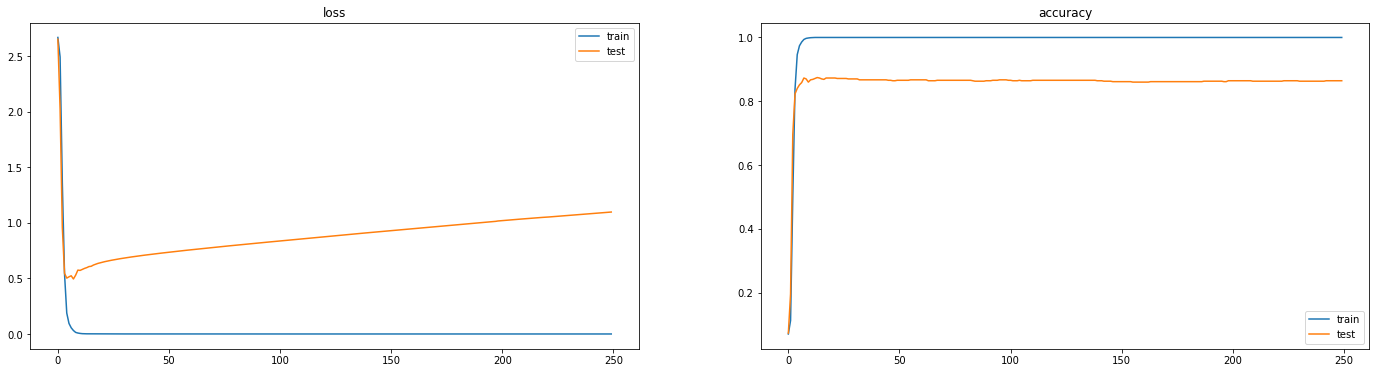

In [149]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_sparse_categorical_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

In [135]:
# 6c. Add gradient clipping to RNN training with clipping threshold = 2.
# for word RNN
model = get_word_rnn(
    vocab_size,
    max_input_length,
    num_categories,
)

adam_clip = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    clipvalue=2,
)
model.compile(
    optimizer=adam_clip,
    loss=loss,
    metrics=metrics,
)

model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 20)           792040    
_________________________________________________________________
gru_11 (GRU)                 (None, 20)                2520      
_________________________________________________________________
dense_25 (Dense)             (None, 15)                315       
Total params: 794,875
Trainable params: 794,875
Non-trainable params: 0
_________________________________________________________________


In [136]:
%%time
history = model.fit(
    train_ds,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_data=test_ds,
    verbose=0,  # too much output may crash browser
)

CPU times: user 3min 3s, sys: 11.6 s, total: 3min 15s
Wall time: 2min 18s


In [137]:
%%time
results = model.evaluate(test_ds, batch_size=batch_size)

6/6 [==============================] - 0s 4ms/step - loss: 1.8993 - sparse_categorical_accuracy: 0.8371
CPU times: user 70.7 ms, sys: 2.69 ms, total: 73.4 ms
Wall time: 73.8 ms


highest validation accuracy achieved: 0.8571428656578064


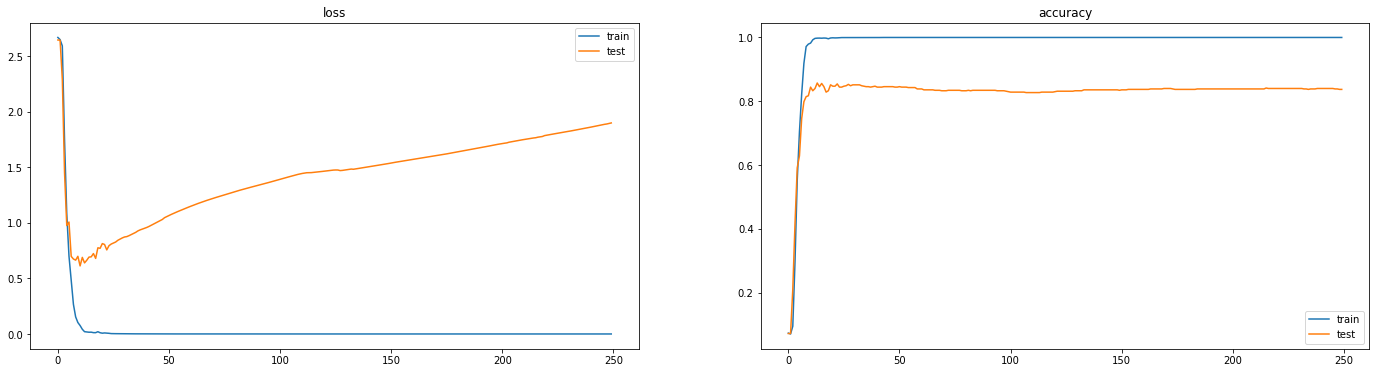

In [138]:
# Plot the entropy cost on the training data and 
# the accuracy on the testing data against training epochs.
plot_loss_accuracy_curves(num_epochs, history.history)

val_accuracies = history.history['val_sparse_categorical_accuracy']
print(f'highest validation accuracy achieved: {max(val_accuracies)}')

comparison of accuracies:

change\classifier|character RNN|word RNN
-|-|-
a.i. vanilla RNN|0.148571|0.097142
a.ii. LSTM|0.694285|0.071428
b. 2 RNN layers|-|0.874285
c. gradient clipping|0.728571|0.857142